#Sistema de classificação de SMSs para classificação de SPAM utilizando o CIB
- Análise Exploratória de Dados
- Pré-processamento dos dados
- Modelo

Grupo: \\
Amanda Cristina Fernandes M. de Lima (acfml) \\
Maria Letícia do N. Gaspar (mlng) \\
Mariana Melo dos Santos (mms11) \\
Victória Barbosa C. Figueiredo(vbcf)

In [ ]:
#importando bibliotecas
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import string #string.punctuation
import nltk #trabalhar com dados de linguagem humana/natural
from nltk.corpus import stopwords #stopwords - conjunto de palavras que não agregam na análise

from sklearn.model_selection import train_test_split #dividir os dados em dois conjuntos: treinamento e teste
from sklearn.feature_extraction.text import CountVectorizer #vetorizador de contagem: conta o número de vezes que um token aparece no documento e usa esse valor como seu peso(matriz de contagem)
#transforma o texto em estruturas numéricas para entendimento do computador
#usar dados textuais para modelagem preditiva
#transformar dados arbitrários como textos/imagens em recursos numéricos compatíveis para aprendizado de máquina
from sklearn.feature_extraction.text import TfidfTransformer #transforma a matriz de contagem para uma representação normalizada tf
from sklearn.naive_bayes import MultinomialNB #contagem de palavras para classificação dos textos
from sklearn.metrics import classification_report, confusion_matrix
#nltk.download()

# 1. Análise Exploratória dos Dados
- visão geral do dataset
- tamanho da mensagem




In [ ]:
#importar database
mensagens = pd.read_csv('spam.csv', encoding = 'latin-1')
mensagens.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
3240,ham,Ok i've sent u da latest version of da project.,NaN,NaN,NaN
4131,ham,Hi baby ive just got back from work and i was ...,NaN,NaN,NaN
5387,ham,I will be gentle baby! Soon you will be taking...,NaN,NaN,NaN
1962,spam,it to 80488. Your 500 free text messages are v...,NaN,NaN,NaN
403,ham,None of that's happening til you get here though,NaN,NaN,NaN


In [ ]:
#apagar as últimas três colunas
mensagens.drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace = True)

#renomear as colunas
mensagens = mensagens.rename(columns = {'v1':'categoria', 'v2': 'mensagem'})

mensagens.sample(5)

,categoria,mensagem
2638,ham,Am in gobi arts college
1642,ham,Sleeping nt feeling well
4574,ham,Not directly behind... Abt 4 rows behind Ì_...
5269,spam,"If you don't, your prize will go to another cu..."
2990,spam,HOT LIVE FANTASIES call now 08707509020 Just 2...


In [ ]:
#agrupamento por categoria (spam or not spam)
mensagens.groupby('categoria').describe()

mensagem                                                            \
             count unique                                                top   
categoria                                                                      
ham           4825   4516                             Sorry, I'll call later   
spam           747    653  Please call our customer service representativ...   

                
          freq  
categoria       
ham         30  
spam         4

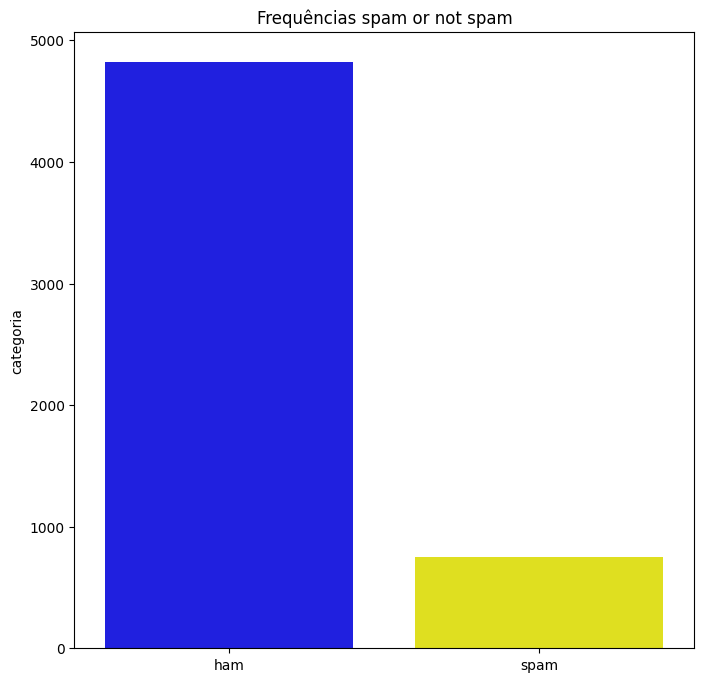

In [ ]:
plt.figure(figsize = [8, 8])

sns.barplot(x = mensagens["categoria"].value_counts().index,
            y = mensagens["categoria"].value_counts(), palette = ['blue', 'yellow']).set(title = "Frequências spam or not spam");

In [ ]:
#cria uma nova coluna que indica por dados numéricos (0,1) se é ou não spam - uso nos modelos de classificação
mensagens['spam'] = mensagens['categoria'].apply(lambda x:1 if x == 'spam' else 0)

#cria uma nova coluna que indica a quantidade de caracteres
mensagens['qtd_caracteres'] = mensagens['mensagem'].apply(len)

#cria uma nova coluna que indica a quantidade de palavras
mensagens['qtd_palavras'] = mensagens['mensagem'].apply(lambda x:len(nltk.word_tokenize(x)))

mensagens.sample(5)

,categoria,mensagem,spam,qtd_caracteres,qtd_palavras
4678,ham,Sry da..jst nw only i came to home..,0,36,11
4091,ham,I remain unconvinced that this isn't an elabor...,0,70,13
1070,ham,"alright, I'll make sure the car is back tonight",0,47,11
3213,ham,"Babe, have you got enough money to pick up bre...",0,105,26
3627,ham,Meeting u is my work. . . Tel me when shall i ...,0,65,17


In [ ]:
#spam
mensagens[mensagens['spam'] == 1][['qtd_caracteres', 'qtd_palavras']].describe()

,qtd_caracteres,qtd_palavras
count,747.000000,747.000000
mean,138.866131,27.891566
std,29.183082,6.867007
min,13.000000,2.000000
25%,132.500000,25.000000
50%,149.000000,29.000000
75%,157.000000,32.000000
max,224.000000,46.000000


In [ ]:
#não spam
mensagens[mensagens['spam'] == 0][['qtd_caracteres', 'qtd_palavras']].describe()

,qtd_caracteres,qtd_palavras
count,4825.000000,4825.000000
mean,71.023627,17.276269
std,58.016023,13.988585
min,2.000000,1.000000
25%,33.000000,8.000000
50%,52.000000,13.000000
75%,92.000000,22.000000
max,910.000000,220.000000


<Axes: xlabel='qtd_caracteres', ylabel='Count'>

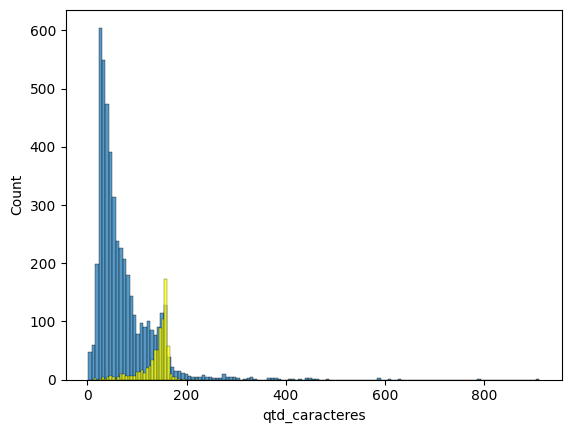

In [ ]:
sns.histplot(mensagens[mensagens['spam'] == 0]['qtd_caracteres']) # emails que não são spam
sns.histplot(mensagens[mensagens['spam'] == 1]['qtd_caracteres'], color = 'yellow') #emails que são spam

<Axes: xlabel='qtd_palavras', ylabel='Count'>

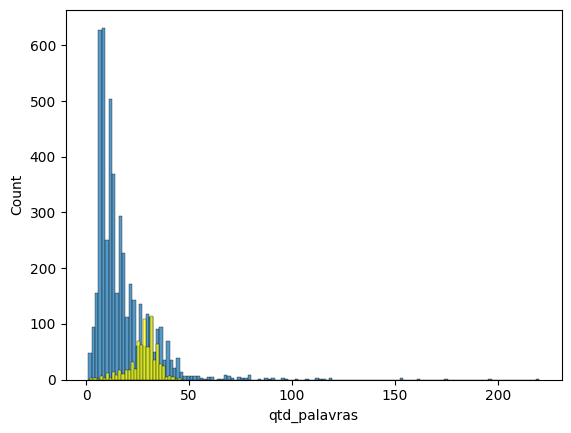

In [ ]:
sns.histplot(mensagens[mensagens['spam'] == 0]['qtd_palavras']) # emails que não são spam
sns.histplot(mensagens[mensagens['spam'] == 1]['qtd_palavras'], color = 'yellow') #emails que são spam

#2. Pré-processamento dos dados
o pré-processamento dos dados inclui:
- conversão das mensagens para letras minúsculas
- remoção de pontuação
- remoção de stopwords
- tokenização
- vetorização
- ponderação TF - IDF

In [ ]:
import string
from nltk.corpus import stopwords

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
stopwords.words('english')[100:105]

['here', 'there', 'when', 'where', 'why']

In [ ]:
def processamento(texto):
  Npunct = [char for char in texto if char not in string.punctuation] #remove as pontuações
  Npunct = ''.join(Npunct)
  sms_limpo = [word.lower() for word in Npunct.split() if word.lower() not in stopwords.words('english')] #remove stopwords
  return sms_limpo

In [ ]:
#cria uma nova coluna com a mensagem sem stopwords e pontuação (apenas os tokens)
mensagens['nova_mensagem'] = mensagens['mensagem'].apply(processamento)

mensagens.sample(5)

,categoria,mensagem,spam,qtd_caracteres,qtd_palavras,nova_mensagem
3523,ham,Yeah that'd pretty much be the best case scenario,0,49,10,"[yeah, thatd, pretty, much, best, case, scenario]"
3444,ham,wiskey Brandy Rum Gin Beer Vodka Scotch Shampa...,0,91,17,"[wiskey, brandy, rum, gin, beer, vodka, scotch..."
1022,ham,We still on for tonight?,0,24,6,"[still, tonight]"
5306,ham,Ill be at yours in about 3 mins but look out f...,0,51,13,"[ill, 3, mins, look]"
4303,ham,"Good good, billy mates all gone. Just been jog...",0,77,18,"[good, good, billy, mates, gone, jogging, enjo..."


In [ ]:
#coloca numa lista as palavras dos sms que não são spam
not_spam_msg = []
sms_limpo = mensagens[mensagens['spam'] == 0]['nova_mensagem'].tolist()
for msg in sms_limpo:
    for word in msg:
        not_spam_msg.append(word)

In [ ]:
#coloca numa lista as palavras dos sms que são spam
spam_msg = []
sms_limpo = mensagens[mensagens['spam'] == 1]['nova_mensagem'].tolist()
for msg in sms_limpo:
    for word in msg:
        spam_msg.append(word)

In [ ]:
from collections import Counter #faz a contagem das palavras
count_spam = Counter(spam_msg)
p_spam  = pd.DataFrame(count_spam.most_common(30),  columns=['palavra', 'count'])
count_not_spam = Counter(not_spam_msg)
p_not_spam = pd.DataFrame(count_not_spam.most_common(30), columns=['palavra', 'count'])

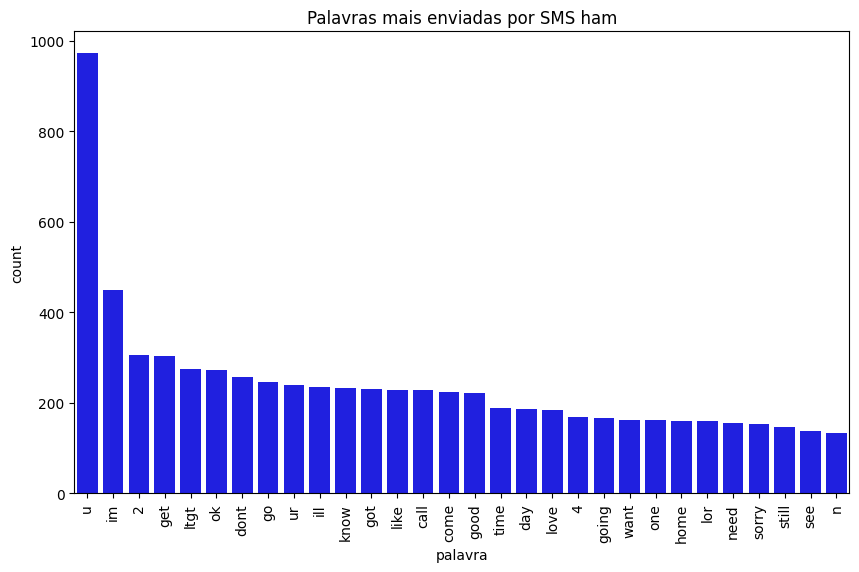

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='palavra', y='count', data=p_not_spam, ax=ax, color = 'blue')
plt.title("Palavras mais enviadas por SMS ham")
plt.xticks(rotation='vertical');

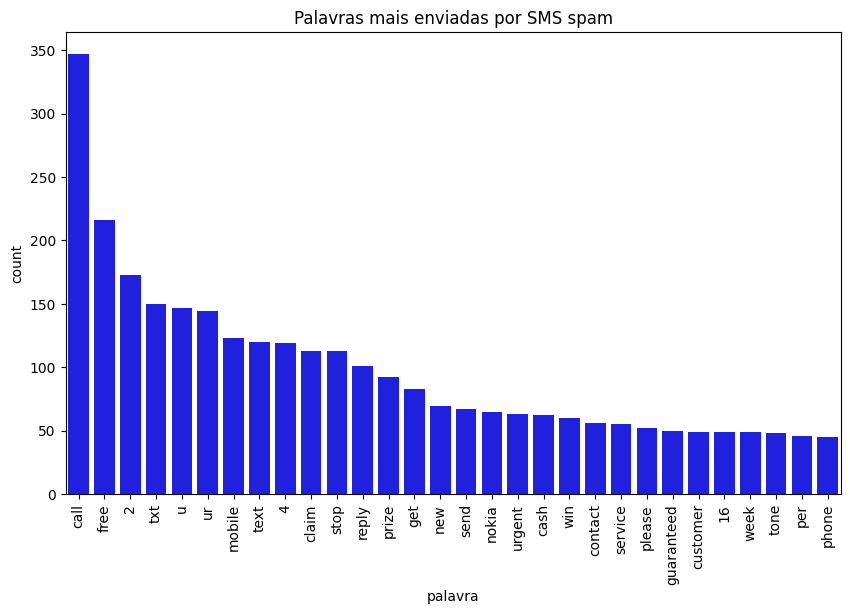

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='palavra', y='count', data=p_spam, ax=ax, color = 'blue')
plt.title("Palavras mais enviadas por SMS spam")
plt.xticks(rotation='vertical');

In [ ]:
mensagens.shape

(5572, 6)

#3. Modelo

In [ ]:
from sklearn.pipeline import Pipeline

#divisão em conjuntos de teste e treinamento

X = mensagens['mensagem'] #recursos
y = mensagens['spam'] #rótulos

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

#bow - bag of words - frequência das palavras no sms
#tfidf - leva mais em consideração palavras com menor frequência - mais informativas
#classifier - escolhe o classificador multinomial do naive bayes
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=processamento)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])
pipeline.fit(X_train, y_train) #treina o modelo
predictions = pipeline.predict(X_test) #testa o modelo - indica no conjunto de teste quem é spam e not spam
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       466
           1       1.00      0.67      0.81        92

    accuracy                           0.95       558
   macro avg       0.97      0.84      0.89       558
weighted avg       0.95      0.95      0.94       558



<Axes: >

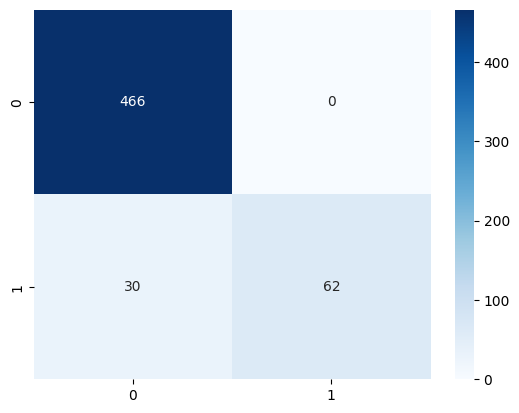

In [ ]:
sns.heatmap(confusion_matrix(y_test,predictions), annot=True, fmt = '.0f', cmap = 'Blues')
#análise do conjunto teste
#(0,0) - verdadeiro positivo - sms que não são spam que foram classificados corretamente
#(0,1) - falso negativo - sms que são spam que foram classificados como não spam
#(1,0) - falso positivo - sms que não são spam que foram classificados como spam
#(1,1) - verdadeiro negativo - sms que são spam que foram classificados corretamente

#4. Testando SMSs

In [ ]:
#teste sms não spam
X_test = ["hey let's play soccer"]
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
print(predictions)

[0]


In [ ]:
#teste sms spam
X_test = ["England v Macedonia - dont miss the goals/team news. Txt ur national team to 87077 eg ENGLAND to 87077 Try:WALES, SCOTLAND 4txt/̼1.20 POBOXox36504W45WQ 16+"]
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
print(predictions)

[1]


In [ ]:
#teste sms spam
X_test = ["Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005.Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
print(predictions)

[1]


In [ ]:
#teste sms não spam
X_test = ["hi friend, how are you today?"]
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
print(predictions)

[0]
